# 1. Prerequisite

1. Importing required packages
2. Reading CSV and creating Data Frame
3. Understand the Data Frame

In [176]:
#Importing Required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
# pd.set_option("display.max_rows", 50)

In [177]:
# Creating dataframe from CSV file
loan = pd.read_csv("./loan/loan.csv")

In [178]:
# Checking the data
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [179]:
# Understanding the shape of the DF
loan.shape

(39717, 111)

In [180]:
# Get the details of the data
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


# 2. Data Cleaning

1. Drop the columns if,
    1. The missing values for that column is > 40%
    2. The column having only one value (unique count is 1) 
    3. The percentage of unique values in a column is less than 2% (e.g. URL - all values are unique)
2. Drop the rows,
    1. We are considering only Closed and Chargged of loans for few scenarios. So we can remove the loan with status 'Current'.
3. Outlier removal - if required.

In [181]:
# Find isnull values in dataset and get the percentage 
missing_values_percentage = loan.isnull().sum() / len(loan) * 100
print(missing_values_percentage)

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
                                 ...    
tax_liens                       0.098195
tot_hi_cred_lim               100.000000
total_bal_ex_mort             100.000000
total_bc_limit                100.000000
total_il_high_credit_limit    100.000000
Length: 111, dtype: float64


In [182]:
# Get coloumns with more than 40% of data
columns_with_missing_data = missing_values_percentage[missing_values_percentage > 40].index
print(columns_with_missing_data)

Index(['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_t

In [183]:
# Drop the columns with more than 40% of miss_dataing data
loan_data = loan.drop(columns=columns_with_missing_data)

In [184]:
loan_data.shape

(39717, 54)

In [185]:
# Checking for the coloumns that still have some missing values
missing_value = loan_data.isnull().sum() / len(loan_data) * 100
find_missing_columns = missing_value[missing_value > 0]
print(find_missing_columns)

emp_title                      6.191303
emp_length                     2.706650
desc                          32.585543
title                          0.027696
revol_util                     0.125891
last_pymnt_d                   0.178765
last_credit_pull_d             0.005036
collections_12_mths_ex_med     0.140998
chargeoff_within_12_mths       0.140998
pub_rec_bankruptcies           1.754916
tax_liens                      0.098195
dtype: float64


In [186]:
# As we have reduce to 54 columns after data cleaning.
# Now we will again check for the columns with the unique counts in them.
unique_col = loan_data.nunique()
print(unique_col)

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
desc                          26526
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths              

In [187]:
# As per the above observation we got the columns with single unique value,
# so it will not affect the analysis
# remove the columns with unique count = 1
uni_col = unique_col[unique_col.values == 1]
unique_col_list = uni_col.index.tolist()
loan_data.drop(columns=unique_col_list, inplace=True)

In [188]:
loan_data.shape

(39717, 45)

In [189]:
# Columns where the number of unique values is greater than 2% 
per_unique_value = loan_data.nunique()
per_uni_col = per_unique_value[per_unique_value > len(loan_data)* .02]
print(per_uni_col)

id                         39717
member_id                  39717
loan_amnt                    885
funded_amnt                 1041
funded_amnt_inv             8205
installment                15383
emp_title                  28820
annual_inc                  5318
url                        39717
desc                       26526
title                      19615
zip_code                     823
dti                         2868
revol_bal                  21711
revol_util                  1089
out_prncp                   1137
out_prncp_inv               1138
total_pymnt                37850
total_pymnt_inv            37518
total_rec_prncp             7976
total_rec_int              35148
total_rec_late_fee          1356
recoveries                  4040
collection_recovery_fee     2616
last_pymnt_amnt            34930
dtype: int64


In [190]:
cols_not_required = ["url", "desc", "title", "emp_title", "zip_code", "out_prncp", "out_prncp_inv", "id", "member_id"]
loan_data.drop(columns=cols_not_required, inplace=True)

In [191]:
loan_data.shape

(39717, 36)

### 2.1. Data Preparation 

In [192]:
#Remove rows where the loan_status is current as current means in-porgress
loan_data_without_current=loan_data.copy()
rows_to_drop = loan_data_without_current[loan_data['loan_status'] == "Current"].index
loan_data_without_current.drop(rows_to_drop, inplace=True)

In [193]:
# loan_data.shape
loan_data.head()
# loan_data.info()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0
1,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
2,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0
3,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
4,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0


# 3. Univariate Analysis

Checking whether the below variables are contributing to loan charged off.
1. Loan Attributes
    1. Term
    2. Int_rate
    3. Grade
    4. Verification status
    5. Funded Amount
2. Consumer Attributes
    1. Purpose
    2. Home Ownership
    3. Annual Income
    4. Open Credid Lines
    5. State
    6. DTI

    

In [194]:
loan_data.loc[:, 'int_rate'] = loan_data['int_rate'].str.strip().str.replace('%', '').astype(float)
loan_data.loc[:, 'term'] = loan_data['term'].str.strip().str.replace(' months', '').astype(int)
charged_off_loan_data = loan_data[loan_data['loan_status']=='Charged Off']
fully_paid_loan_data = loan_data[loan_data['loan_status']=='Fully Paid']


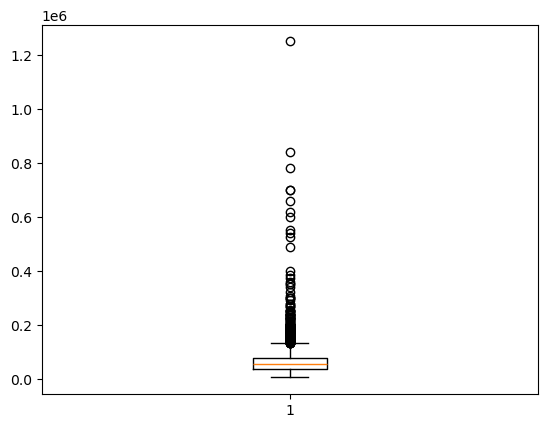

In [195]:
#Analysing outlier
plt.boxplot(charged_off_loan_data["annual_inc"])
plt.show()

In [196]:
#Removing outlier
annual_inc_data = charged_off_loan_data["annual_inc"]
annual_inc_data=annual_inc_data[annual_inc_data<200000]

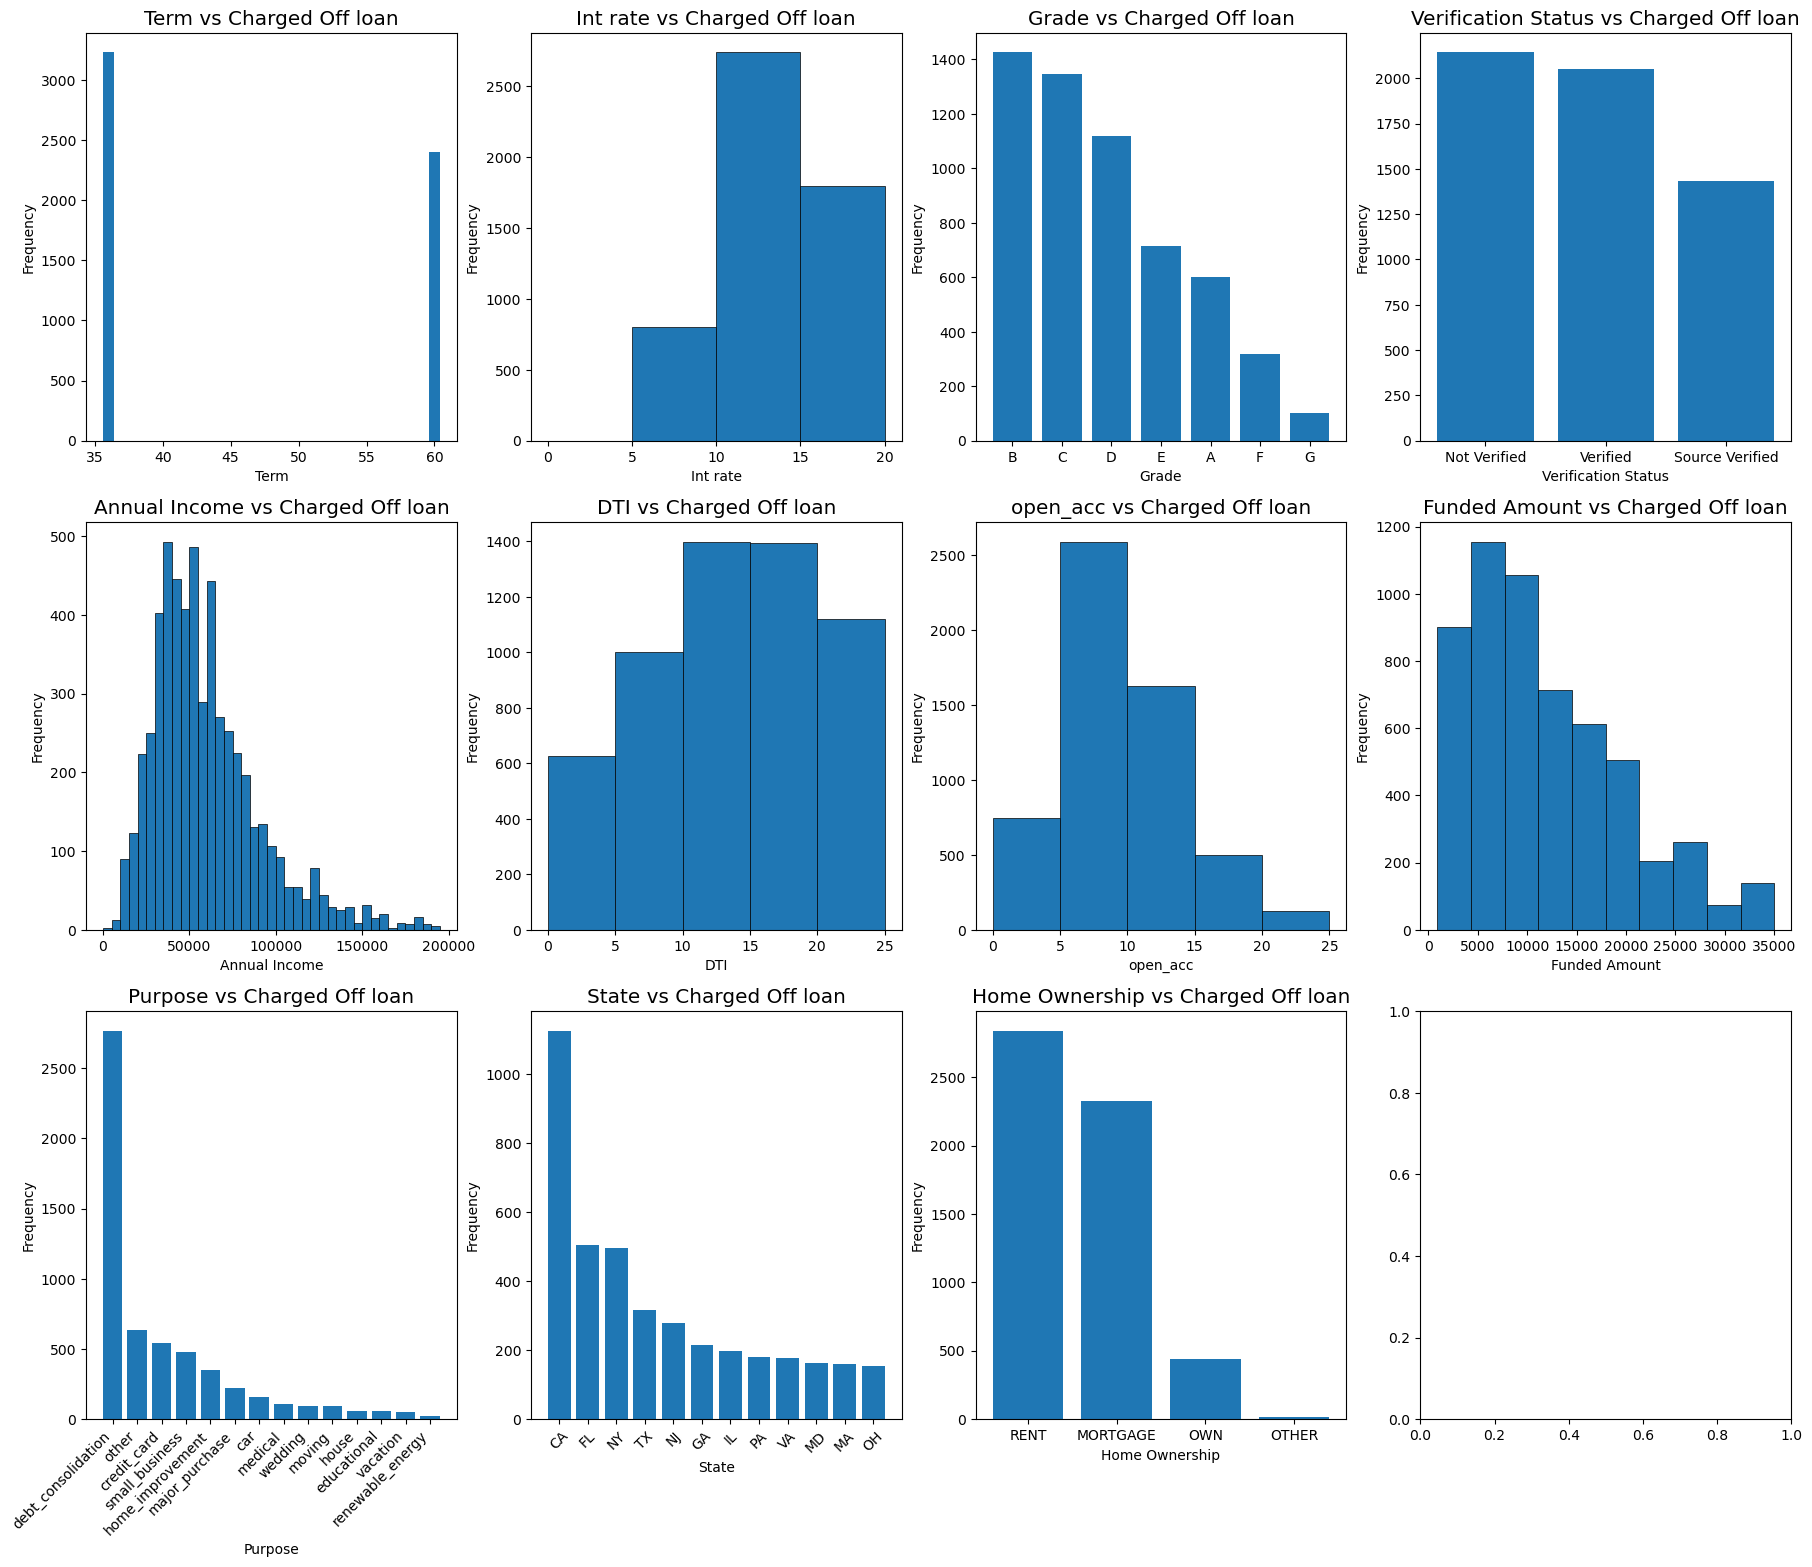

In [197]:

# Plotting subplots, so that all the univarate analysis can see together 
fig, axs = plt.subplots(nrows=3,ncols=4, figsize=(22, 18))
plt.style.use('ggplot')

# Term vs charged off - plotting bar grarph, x axis is term, y axis is count
df = charged_off_loan_data["term"].value_counts()
axs[0,0].bar(df.index, df.values)
axs[0,0].set_title('Term vs Charged Off loan')
axs[0,0].set_xlabel('Term')
axs[0,0].set_ylabel('Frequency')

# int_date vs charged off - plotting histogram grarph
axs[0,1].hist(charged_off_loan_data["int_rate"], bins=np.arange(0,25,5), edgecolor='black')
axs[0,1].set_title('Int rate vs Charged Off loan')
axs[0,1].set_xlabel('Int rate')
axs[0,1].set_ylabel('Frequency')

# Grade vs charged off - plotting bar grarph, x axis is grade, y axis is count
df = charged_off_loan_data["grade"].value_counts()
axs[0,2].bar(df.index, df.values)
axs[0,2].set_title('Grade vs Charged Off loan')
axs[0,2].set_xlabel('Grade')
axs[0,2].set_ylabel('Frequency')

# Verification Status vs charged off - plotting bar grarph, x axis is status, y axis is count
df = charged_off_loan_data["verification_status"].value_counts()
axs[0, 3].bar(df.index, df.values)
axs[0, 3].set_title('Verification Status vs Charged Off loan')
axs[0, 3].set_xlabel('Verification Status')
axs[0, 3].set_ylabel('Frequency')

# Income vs charged off
axs[1, 0].hist(annual_inc_data, bins=np.arange(0,200000,5000), edgecolor='black')
axs[1, 0].set_title('Annual Income vs Charged Off loan')
axs[1, 0].set_xlabel('Annual Income')
axs[1, 0].set_ylabel('Frequency')

# DTI vs charged off - plotting hist graph
axs[1, 1].hist(charged_off_loan_data["dti"], bins=np.arange(0,30,5), edgecolor='black')
axs[1, 1].set_title('DTI vs Charged Off loan')
axs[1, 1].set_xlabel('DTI')
axs[1, 1].set_ylabel('Frequency')

# funded_amnt vs charged off - plotting hist graph
axs[1, 3].hist(charged_off_loan_data["funded_amnt"], bins=10, edgecolor='black')
axs[1, 3].set_title('Funded Amount vs Charged Off loan')
axs[1, 3].set_xlabel('Funded Amount')
axs[1, 3].set_ylabel('Frequency')

# open_acc vs charged off - plotting hist graph
axs[1, 2].hist(charged_off_loan_data["open_acc"], bins=np.arange(0,30,5), edgecolor='black')
axs[1, 2].set_title('open_acc vs Charged Off loan')
axs[1, 2].set_xlabel('open_acc')
axs[1, 2].set_ylabel('Frequency')

# Purpose vs charged off - plotting bar grarph, x axis is purpose, y axis is count
df = charged_off_loan_data["purpose"].value_counts()
axs[2, 0].bar(df.index, df.values)
axs[2, 0].set_title('Purpose vs Charged Off loan')
axs[2, 0].set_xlabel('Purpose')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_xticklabels(df.index, rotation=45, ha='right')

# Customer State vs charged off - plotting bar grarph, x axis is purpose, y axis is count
df = charged_off_loan_data["addr_state"].value_counts()
# Filtering again to plot the graph properly
df = df[df.values>150]
axs[2, 1].bar(df.index, df.values)
axs[2, 1].set_title('State vs Charged Off loan')
axs[2, 1].set_xlabel('State')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].set_xticklabels(df.index, rotation=45)

# Home ownership vs charged off - plotting bar grarph, x axis is status, y axis is count
df = charged_off_loan_data["home_ownership"].value_counts()
axs[2, 2].bar(df.index, df.values)
axs[2, 2].set_title('Home Ownership vs Charged Off loan')
axs[2, 2].set_xlabel('Home Ownership')
axs[2, 2].set_ylabel('Frequency')

plt.show()

In [198]:
#Resetting the style
plt.rcdefaults()

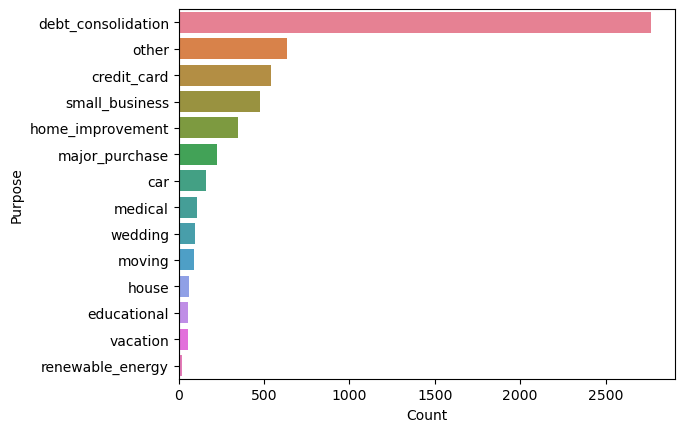

In [199]:
# Ploting a meaningfull graph for showing how purpose is impacting the loan charged of
df = charged_off_loan_data["purpose"].value_counts().reset_index()
df.columns = ['Purpose', 'Count']
colors = sns.color_palette("husl", len(df))
sns.barplot(data=df, y='Purpose', x='Count', palette=colors)
plt.show()

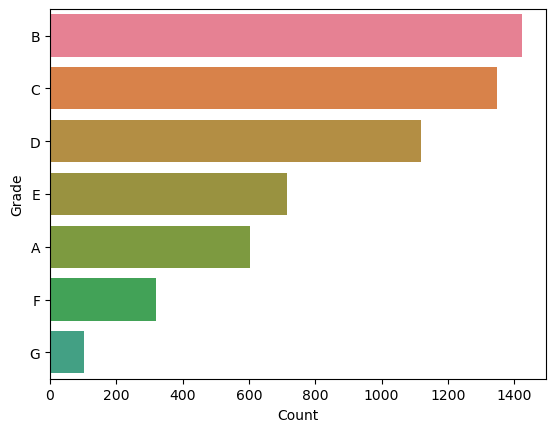

In [200]:
# Ploting a meaningfull graph for showing how Grade is impacting the loan charged of
df = charged_off_loan_data["grade"].value_counts().reset_index()
df.columns = ['Grade', 'Count']
sns.barplot(data=df, y='Grade', x='Count', palette=colors)
plt.show()

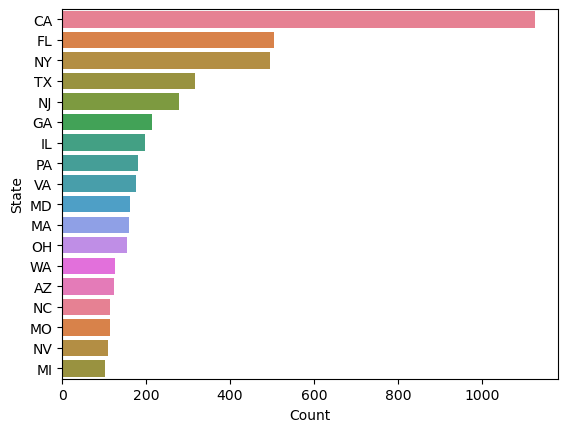

In [201]:
# Customer State vs charged off - plotting bar grarph, x axis is purpose, y axis is count
df = charged_off_loan_data["addr_state"].value_counts()
# Filtering again to plot the graph properly
df = df[df.values>100]
df=df.reset_index()
df.columns = ['State', 'Count']
sns.barplot(data=df, y='State', x='Count', palette=colors)
plt.show()

# 3. Multivariate Analysis

## Scenario: LC can approve loan but reduce the loan amount

1. Loan purpose vs requested amount. If a consumer is asking too much money for the ‘purpose’, in that case LC can reduce the amount.


count    39717.000000
mean     10947.713196
std       7187.238670
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

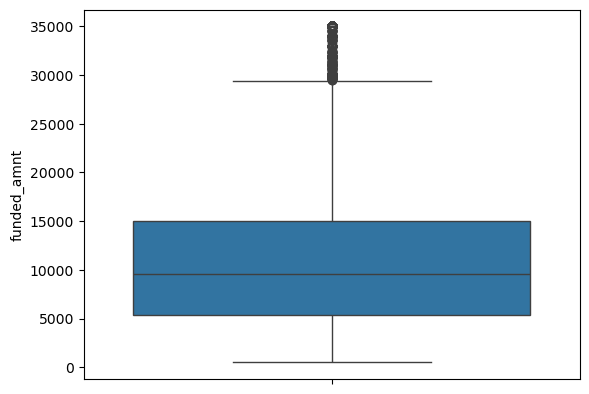

In [202]:
# Checking for any outliers for funded_amnt
sns.boxplot(loan_data['funded_amnt'])
loan_data['funded_amnt'].describe()

In [203]:
# Since not much outliers and the data is normally distributed we can use mean
pt = pd.pivot_table(data=loan_data,index='purpose', values='funded_amnt')
pt = pt.astype(int)
df = pt.reset_index()
df.columns = ['Purpose', 'Average Loan Amount']
df

,Purpose,Average Loan Amount
0,car,6714
1,credit_card,11452
2,debt_consolidation,12388
3,educational,6692
4,home_improvement,11220
5,house,12712
6,major_purchase,7970
7,medical,8103
8,moving,6506
9,other,7893


2. Correlation Matrics


<Axes: >

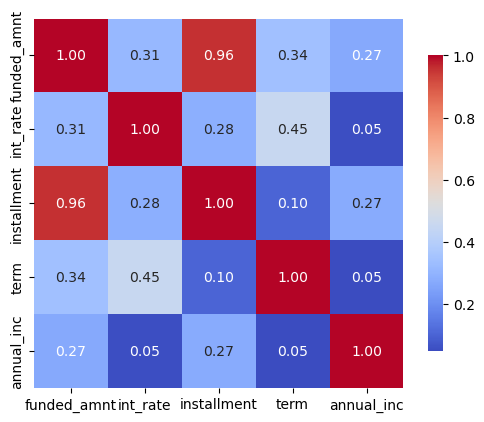

In [205]:
df = loan_data[['funded_amnt','int_rate','installment','term', 'annual_inc']]
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
